In [14]:

import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

In [15]:
# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 30
TRAIN_DIR = "../../data5/train"
TEST_DIR = "../../data5/test"

# Create data generators with IncptionV3-specific preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())

print("Number of classes:", num_classes)
print("Class labels:", class_labels)
# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Found 5999 images belonging to 4 classes.
Found 2576 images belonging to 4 classes.
Number of classes: 4
Class labels: ['Acne', 'Eczema', 'Infection', 'Malignant']


In [16]:

# Improved Hybrid Model
def build_improved_hybrid_model(num_classes):
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for base_model in [resnet_base, vgg_base, inception_base]:
        base_model.trainable = False

    input_tensor = Input(shape=(224, 224, 3))
    resnet_output = GlobalAveragePooling2D()(resnet_base(input_tensor))
    vgg_output = GlobalAveragePooling2D()(vgg_base(input_tensor))
    inception_output = GlobalAveragePooling2D()(inception_base(input_tensor))

    # Add normalization before concatenation
    resnet_output = BatchNormalization()(resnet_output)
    vgg_output = BatchNormalization()(vgg_output)
    inception_output = BatchNormalization()(inception_output)

    merged = concatenate([resnet_output, vgg_output, inception_output])
    x = Dense(512, activation='relu')(merged)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x) 
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model

model = build_improved_hybrid_model(num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
    

In [17]:

# Fine-Tuning the Improved Hybrid Model
def fine_tune_model(model, train_generator, validation_generator, base_models, fine_tune_layers, learning_rate=1e-5, epochs=10):
    for base_model, layers_to_unfreeze in zip(base_models, fine_tune_layers):
        for layer in base_model.layers[-layers_to_unfreeze:]:
            layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

    fine_tune_history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler]
    )
    return fine_tune_history

resnet_base = model.get_layer("resnet50")
vgg_base = model.get_layer("vgg16")
inception_base = model.get_layer("inception_v3")
fine_tune_layers = [20, 10, 15]  # Increased unfreezing

fine_tune_history = fine_tune_model(
    model,
    train_generator,
    test_generator,
    base_models=[resnet_base, vgg_base, inception_base],
    fine_tune_layers=fine_tune_layers,
    learning_rate=1e-5,
    epochs=20
)
    

Epoch 1/20
47/47 [==============================] - 1543s 33s/step - loss: 1.6412 - accuracy: 0.3267 - auc: 0.5788 - val_loss: 1.2699 - val_accuracy: 0.4534 - val_auc: 0.6971 - lr: 1.0000e-05
Epoch 2/20
47/47 [==============================] - 1947s 42s/step - loss: 1.3585 - accuracy: 0.4487 - auc: 0.6961 - val_loss: 1.0706 - val_accuracy: 0.5660 - val_auc: 0.8017 - lr: 1.0000e-05
Epoch 3/20
47/47 [==============================] - 1385s 29s/step - loss: 1.1995 - accuracy: 0.5093 - auc: 0.7583 - val_loss: 0.9653 - val_accuracy: 0.6056 - val_auc: 0.8412 - lr: 1.0000e-05
Epoch 4/20
47/47 [==============================] - 1318s 28s/step - loss: 1.1196 - accuracy: 0.5514 - auc: 0.7900 - val_loss: 0.9055 - val_accuracy: 0.6269 - val_auc: 0.8595 - lr: 1.0000e-05
Epoch 5/20
47/47 [==============================] - 1304s 28s/step - loss: 1.0497 - accuracy: 0.5774 - auc: 0.8164 - val_loss: 0.8666 - val_accuracy: 0.6398 - val_auc: 0.8714 - lr: 1.0000e-05
Epoch 6/20
47/47 [======================

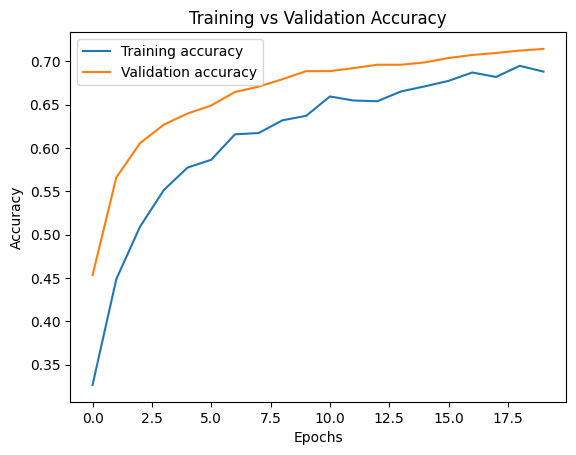

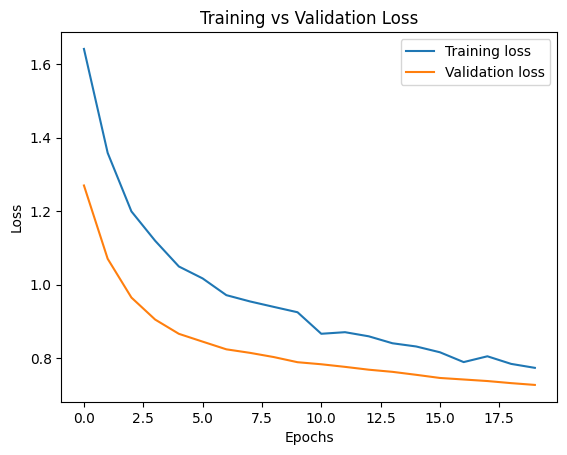

In [18]:
import matplotlib.pyplot as plt

def plot_training_results(history, metrics=["accuracy", "loss"]):
    """
    Plots training and validation metrics for each metric in the list.

    Parameters:
    - history: The history object returned by model.fit().
    - metrics: A list of metric names to plot (e.g., ["accuracy", "loss"]).
    """
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f"Training {metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
        plt.title(f"Training vs Validation {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

# Plot accuracy and loss for the initial training
plot_training_results(fine_tune_history, metrics=["accuracy", "loss"])


In [25]:
model.save("../../models/improved_hybrid_model_batch128.keras")

In [21]:

# Evaluate the Improved Model
results = model.evaluate(test_generator)
print(f"Validation Loss: {results[0]:.2f}")
print(f"Validation Accuracy: {results[1]:.2f}")

# Classification report and confusion matrix
val_preds = np.argmax(model.predict(test_generator), axis=1)
true_labels = test_generator.classes
print(classification_report(true_labels, val_preds, target_names=test_generator.class_indices.keys()))
print(confusion_matrix(true_labels, val_preds))
    

21/21 [==============================] - 433s 21s/step - loss: 0.7277 - accuracy: 0.7143 - auc: 0.9137
Validation Loss: 0.73
Validation Accuracy: 0.71
21/21 [==============================] - 474s 22s/step
              precision    recall  f1-score   support

        Acne       0.83      0.76      0.79       626
      Eczema       0.63      0.66      0.64       650
   Infection       0.55      0.61      0.58       650
   Malignant       0.90      0.83      0.87       650

    accuracy                           0.71      2576
   macro avg       0.73      0.71      0.72      2576
weighted avg       0.73      0.71      0.72      2576

[[474  48  91  13]
 [ 42 426 163  19]
 [ 49 175 398  28]
 [  7  31  70 542]]


In [19]:
import tensorflow as tf; print(tf.__version__)

2.15.0


21/21 [==============================] - 444s 21s/step

Classification Report:
              precision    recall  f1-score   support

        Acne       0.83      0.76      0.79       626
      Eczema       0.63      0.66      0.64       650
   Infection       0.55      0.61      0.58       650
   Malignant       0.90      0.83      0.87       650

    accuracy                           0.71      2576
   macro avg       0.73      0.71      0.72      2576
weighted avg       0.73      0.71      0.72      2576

Confusion Matrix:
[[474  48  91  13]
 [ 42 426 163  19]
 [ 49 175 398  28]
 [  7  31  70 542]]


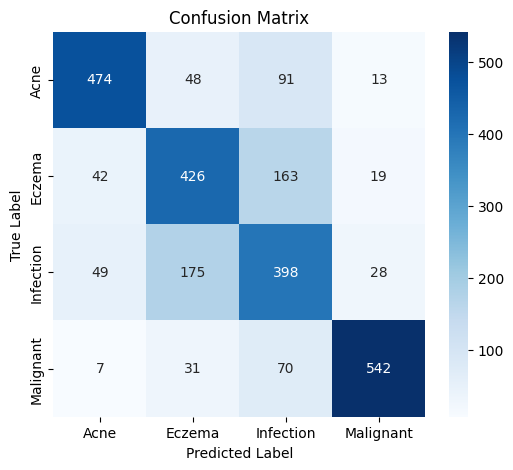

In [23]:
import seaborn as sns 
# Predict class probabilities
y_pred_probs = model.predict(test_generator)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels from the test generator
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

Macro-average ROC AUC: 0.9019436807490315
Micro-average ROC AUC: 0.9139916215777426


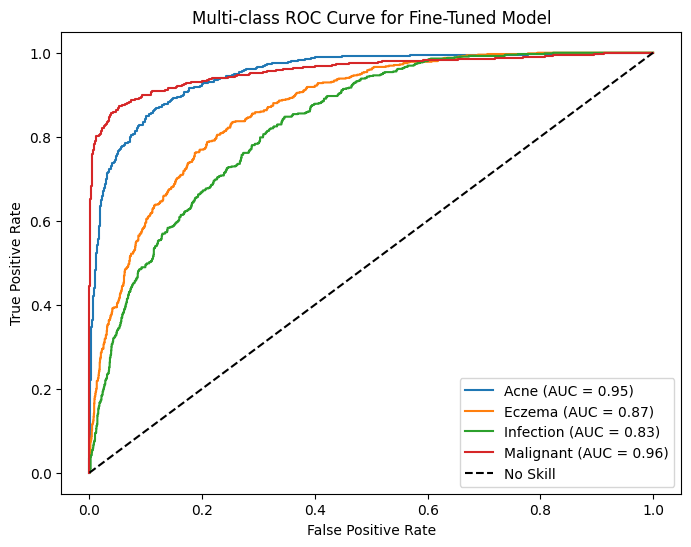

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
y_true_indices = test_generator.classes

# 8. Multi-class ROC & AUC
y_true_binarized = label_binarize(y_true_indices, classes=range(num_classes))

macro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='macro')
micro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='micro')
print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

fpr = {}
tpr = {}
roc_auc_classwise = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_classwise[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_labels[i], roc_auc_classwise[i]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve for Fine-Tuned Model')
plt.legend(loc='lower right')
plt.show()